# Desequilibrio choice


Al usar un modelo choice, se calcula la probabilidad de que un hogar elija una localización dependiendo de su función de utilidad. Se considerarán cuatro tipos de agentes: Comercio, Hogares tipo 1, Hogares tipo 2 y Hogares tipo 3. En este caso la utilidad dependerá de la accesibilidad a educación, accesibilidad a comercio, la cantidad de hogares de tipo 1 en la zona y el precio de la localización. 

Para un agente h, la probabilidad de loacalizarse en la zona i se calcula de la siguiente forma:

$P(i│h)=exp⁡(μ(DP_hi (β_h,x_i)-αr_i))/(∑_jexp⁡(μ(DP_hj(β_h,x_j)-αr_j)))$

## Simulación

En este ejemplo tenemos tres archivos para leer: 
1. **zonas_t0.txt**: Indica la cantidad de agentes de cada tipo que existen en cada zona, con su respectiva capacidad restante para residencial y no residencial y el precio.
2. **agentes_por_localizar.txt**: Indica cuántos quieren localizarse para cada tipo de agente en cada uno de los periodos en el horizonte de simulación.
3. **C_ij.txt**: Matriz de costos de viaje entre cada par origen destino.

Para hacer la simulación solo es necesario importar tres librerías bastante comunes: 

In [1]:
import math
from copy import copy
import random

Luego para leer los archivos txt creamos una función de lectura que nos será útil para todos los archivos. El resultado de la función es una lista de listas con los datos.

In [2]:
def leer_archivo(nombre_archivo):
    lista_datos = []
    archivo_aux=open(nombre_archivo, 'r')
    linea = archivo_aux.readlines()
    for l in linea:
        if linea.index(l)>=1:
            lista_datos.append(l.split())
    archivo_aux.close()
    return lista_datos

zonas = leer_archivo("zonas_t0.txt")            
por_localizar = leer_archivo("agentes_por_localizar.txt")
costos = leer_archivo("C_ij.txt")

Para hacer el código más ordenado vamos a hacer dos clases, zonas y por_localizar_obj que van a poder instanciarse como diccionarios y podremos iterar facilmente. Ambos diccionarios se usarán constantemente en distintas funciones, por lo tanto se los asignamos como variables globales. Los costos también se generarán como diccionario.

In [3]:
#clase zona con todos sus valores
class zona_obj:
    def __init__(self, idi, comercio, educacion, n_h1, 
                 n_h2, n_h3, cap_res, cap_no_res, precio):
        self.id = idi
        self.comercio = comercio
        self.educacion = educacion
        self.n_h1= n_h1
        self.n_h2= n_h2
        self.n_h3= n_h3
        self.cap_res = cap_res
        self.cap_no_res = cap_no_res
        self.precio = precio

#clase de agentes por localizar por periodo
class por_localizar_obj:
    def __init__(self, periodo, comercio, h1, h2, h3):
        self.periodo = periodo
        self.comercio = comercio
        self.n_h1 = h1
        self.n_h2 = h2
        self.n_h3 = h3
        
global zona
zona = {}
global por_localizar_dict
por_localizar_dict = {}
costos_dict ={}

# diccionario para mis zonas (que son objetos de la clase zona_obj)
for t in range(0, len(por_localizar)):
    for z in zonas:
        idi = int(z[0])
        comercio = int(z[1])
        educacion = int(z[2])
        n_h1 = int(z[3])
        n_h2 = int(z[4])
        n_h3 = int(z[5])
        cap_res = int(z[6])
        cap_no_res = int(z[7])
        precio= int(z[8])
        zona[t ,int(z[0])]=zona_obj(idi, comercio, educacion, n_h1,
                     n_h2, n_h3, cap_res, cap_no_res, precio)

#diccionario para mis agentes por localizar donde la llave es el periodo 
for t in por_localizar:
    periodo, comercio, h1, h2, h3 = int(t[0]), int(t[1]), int(t[2]), int(t[3]), int(t[4])
    por_localizar_dict[int(t[0])]= por_localizar_obj(periodo,comercio,h1, h2,h3)
    
n_zonas= len(costos)
for fila in costos:
    for n in range(1,(n_zonas+1)):
        costos_dict[int(fila[0]), n] = int(fila[n])

Definición de parámetros, phi, mu y el periodo inicial para mi simulación:

In [4]:
phi = 0.2
mu = 0.1
alpha = 0.2

Ahora debo calcular accesibilidad gravitacional para luego calcular la probabilidad de locaclización y con esta asignar una localización. Para cada uno de estos pasos se crearon una o más funciones:

In [5]:
def calcular_accesibilidad(periodo, zona, costos_dict, n_zonas, phi):        
    Accesibilidad_comercio= []
    Accesibilidad_educacion = []
    for i in range(1,(n_zonas+1)):
        acc_aux_comercio = 0
        acc_aux_educacion = 0
        for j in range(1, (n_zonas+1)):
            acc_aux_comercio += zona[periodo,j].comercio*math.exp(-phi*costos_dict[i,j])
            acc_aux_educacion += zona[periodo,j].educacion*math.exp(-phi*costos_dict[i,j])
        Accesibilidad_comercio.append(int(acc_aux_comercio))
        Accesibilidad_educacion.append(int(acc_aux_educacion))
    return Accesibilidad_comercio, Accesibilidad_educacion

# similar a esto podrían recalcularse los precios. En este ejemplo están fijos pero deberían ser endógenos.



La función de utilidad es evaluada con los atributos del periodo anterior. Además es necesario usar un vector que indique su peso o relevancia dentro de la función de utilidad, que llamamos x_agentes y es un diccionario con dos llaves, el agente y un número 0, 1, 2 o 3 que indica el parámetro accesibilidad educacional, accesibilidad comercio, número de hogares tipo 1 y precio respectivamente.

In [6]:
def calcular_DP(beta, acc_comercio, acc_educacion, zona, periodo):
    n_zonas = len(acc_comercio)
    t = periodo
    DP ={}
    for i in range(1, n_zonas + 1):
        for agente in x_agentes:
            DP[agente,i] = (x_agentes[agente][0]*acc_educacion[i-1] 
                          + x_agentes[agente][1]*acc_comercio[i-1]
                          + x_agentes[agente][2]*zona[t,i].n_h1
                          + x_agentes[agente][3]*zona[t,i].precio)     
    return DP

def calcular_probabilidad(x_agentes, n_zonas, zona, DP, alpha, mu, t):
    prob_aux2 = 0
    prob_aux1 = {}
    prob= {}
    for h in x_agentes:
        prob_aux = 0
        for i in range(1, (n_zonas + 1)):
            #print(zona[t,i].precio)
            prob_aux += math.exp(mu*(DP[h,i]-alpha*zona[t,i].precio))
        prob_aux1[h] = prob_aux
    
    for h in x_agentes:
        for i in range(1, (n_zonas+1)):
            prob_aux2 = math.exp(mu*(DP[h,i]-alpha*zona[t,i].precio))
            prob_aux3 = prob_aux1[h]
            prob[i,h]= prob_aux2/prob_aux3
    return prob

Se hace una función que genere una lista ordenada para facilitar la implementación de la simulación de monte carlo. Esta es una lista con la suma acumulada de las probabilidades que solo toma en cuenta las zonas en donde sí queda capacidad de localización.

In [7]:
def MC_hacerlista(probabiliad,agente, n_zonas, t):
    P_mc = {}
    P_mc2 = {}
    aux_suma = 0
    if agente == "comercio":
        for i in range(1,n_zonas+1):
            if zona[t,i].cap_no_res > 0:
                aux_suma += probabilidad[i, agente]
                P_mc[i]=aux_suma
    else:
        for i in range(1,n_zonas+1):
            if zona[t,i].cap_res > 0:
                aux_suma += probabilidad[i, agente]
                P_mc[i]=aux_suma
    for i in P_mc:
        P_mc2[i] = P_mc[i]/aux_suma
    return P_mc2

Hacemos una función para localizar que actualiza los valores de cada diccionario para el periodo respectivo.

In [8]:
def localizar(i_selec, t, agente):
    if agente == "comercio":
        zona[t,i_selec].cap_no_res -= 1
        por_localizar_dict[t].comercio -= 1
        zona[t,i_selec].comercio +=1
    elif agente == "n_h1": 
        zona[t,i_selec].cap_res -= 1
        por_localizar_dict[t].n_h1 -= 1
        zona[t,i_selec].n_h1 +=1
    elif agente == "n_h2": 
        zona[t,i_selec].cap_res -= 1
        por_localizar_dict[t].n_h2 -= 1
        zona[t,i_selec].n_h2 +=1
    elif agente == "n_h3": 
        zona[t,i_selec].cap_res -= 1
        por_localizar_dict[t].n_h3 -= 1
        zona[t,i_selec].n_h3 +=1
        return



In [9]:
x_agentes = {"comercio":[0, 0.9, 0.4, -0.02],"n_h1":[0.03, 0.1, 0.4, 0.01],
             "n_h2":[0.04, 0.2, 0.25, -0.04],"n_h3":[0.03, 0.2, 0.2, -0.5]}

Con todo lo anterior, llegamos a lo que sería la simulación misma. Algunos detalles que hay que tener un cuenta:

    -Notar que en la primera iteración no se revisa qué agentes hay disponibles. Sí lo deberían hacer para su modelo, ya que de otra forma podrían caer en errores.
    
    -La función DP y probabilidad se calculan en base a los valores del periodo anterior.

    -Se usa la función copy para que los valores no se igualen por referencia, sino que solo tomen el valor.
    

In [10]:
for t in range(1, len(por_localizar)):
    #se asume que al comienzo todos los agentes podrian querer localizarse
    #esto puede no ser cierto
    agentes_no_localizados = ["comercio","n_h1","n_h2","n_h3"]
    acc_comercio, acc_educacion = calcular_accesibilidad(t-1, zona, costos_dict, n_zonas, phi)
    DP = calcular_DP(x_agentes, acc_comercio, acc_educacion, zona, t-1)
    probabilidad = calcular_probabilidad(x_agentes, n_zonas, zona, DP, alpha, mu, t-1)
    
    #OJO: calcule las DP segun las localizaciones del periodo anterior
    #la localizacion la hago con el periodo actual
    while agentes_no_localizados:
        #Elijo un agente al azar y aplico monte carlo
        agente_azar= random.choice(agentes_no_localizados)
        P_mc = MC_hacerlista(probabilidad,agente_azar, n_zonas,t)
        dado = random.random()
        for p in P_mc:
            if P_mc[p] >= dado:
                localizar(p, t, agente_azar)
                break
        #despues de localizar reviso que agentes necesitan
        #localizarse para volver hacer el random por agentes
        agentes_no_localizados = []
        if por_localizar_dict[t].comercio > 0:
            agentes_no_localizados.append("comercio")
        if por_localizar_dict[t].n_h1 > 0:
            agentes_no_localizados.append("n_h1")
        if por_localizar_dict[t].n_h2 > 0:
            agentes_no_localizados.append("n_h2")
        if por_localizar_dict[t].n_h3 > 0:
            agentes_no_localizados.append("n_h3")
    #terminando actualizo el periodo t+1 que comienza con las localizaciones
    #del periodo anterior

    for i in range(1, n_zonas+1):
        zona[t+1,i] = copy(zona[t,i])


In [11]:
import numpy as np
import matplotlib.pyplot as plt
def plot_lineas(zona,zonas, t):
    comercio = []
    H1 = []
    H2 = []
    H3 = []
    eje_zonas = []
    for i in range(1, len(zonas)+1):
        comercio.append(zona[t, i].comercio)
        H1.append(zona[t, i].n_h1)
        H2.append(zona[t, i].n_h2)
        H3.append(zona[t, i].n_h3)
        eje_zonas.append(i)
    ind = [x for x, _ in enumerate(eje_zonas)]
    H1 = np.array(H1)
    H2 = np.array(H2)
    H3 = np.array(H3)
    comercio= np.array(comercio)
    plt.figure(figsize=(20,12))
    plt.bar(ind, H1, width=0.8, label='H1', color='#3498DB', bottom=H3+H2)
    plt.bar(ind, H2, width=0.8, label='H2', color='#2874A6', bottom=H3)
    plt.bar(ind, H3, width=0.8, label='H3', color='#1B4F72')
    plt.bar(ind, comercio, width=0.8, label='Comercio', color='#AF7AC5',bottom=H3+H2+H1)
    
            
    plt.xticks(ind, eje_zonas)
    plt.ylabel("Agentes")
    plt.xlabel("zonas")
    plt.legend(loc="upper right")
    plt.title("Localizacion periodo " + str(t))    
    plt.show()
    
def plot_comparar(zona,zonas, t,t2):
    localizados1 = []
    localizados2 = []
    aux = 0
    aux2 = 0
    eje_zonas = []
    for i in range(1, len(zonas)+1):
        aux = (zona[t, i].comercio +
        zona[t, i].n_h1 + zona[t, i].n_h2
        + zona[t, i].n_h3)
        aux2 = (zona[t2, i].comercio +
        zona[t2, i].n_h1 + zona[t2, i].n_h2
        + zona[t2, i].n_h3)
        eje_zonas.append(i)
        localizados1.append(aux)
        localizados2.append(aux2)
    print(localizados2[93])
    ind = [x for x, _ in enumerate(eje_zonas)]
    t1 = np.array(localizados1)
    t22 = np.array(localizados2)
    plt.figure(figsize=(25,13))
    plt.plot(ind, t1, label='periodo ' + str(t), color='red')
    plt.plot(ind, t22, label='periodo ' + str(t2), color='blue')   
    plt.xticks(ind, eje_zonas)
    plt.ylabel("Agentes")
    plt.xlabel("zonas")
    plt.legend(loc="upper right")
    plt.title("Localizacion periodo " + str(t) + " y "+ str(t2))    
    plt.show()

El primero es para la cantidad de agentes por tipo para cada periodo.

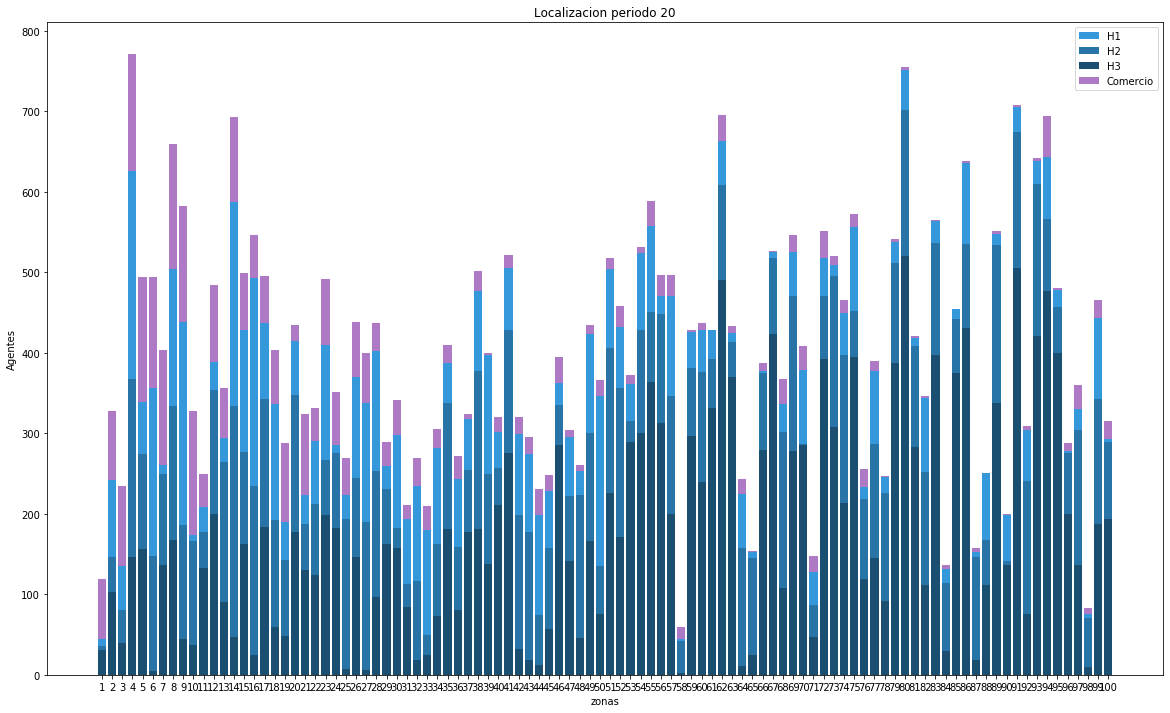

In [12]:
plot_lineas(zona,zonas,20)

El segundo sirve para comparar la localización entre dos periodos distintos para todas las zonas

694


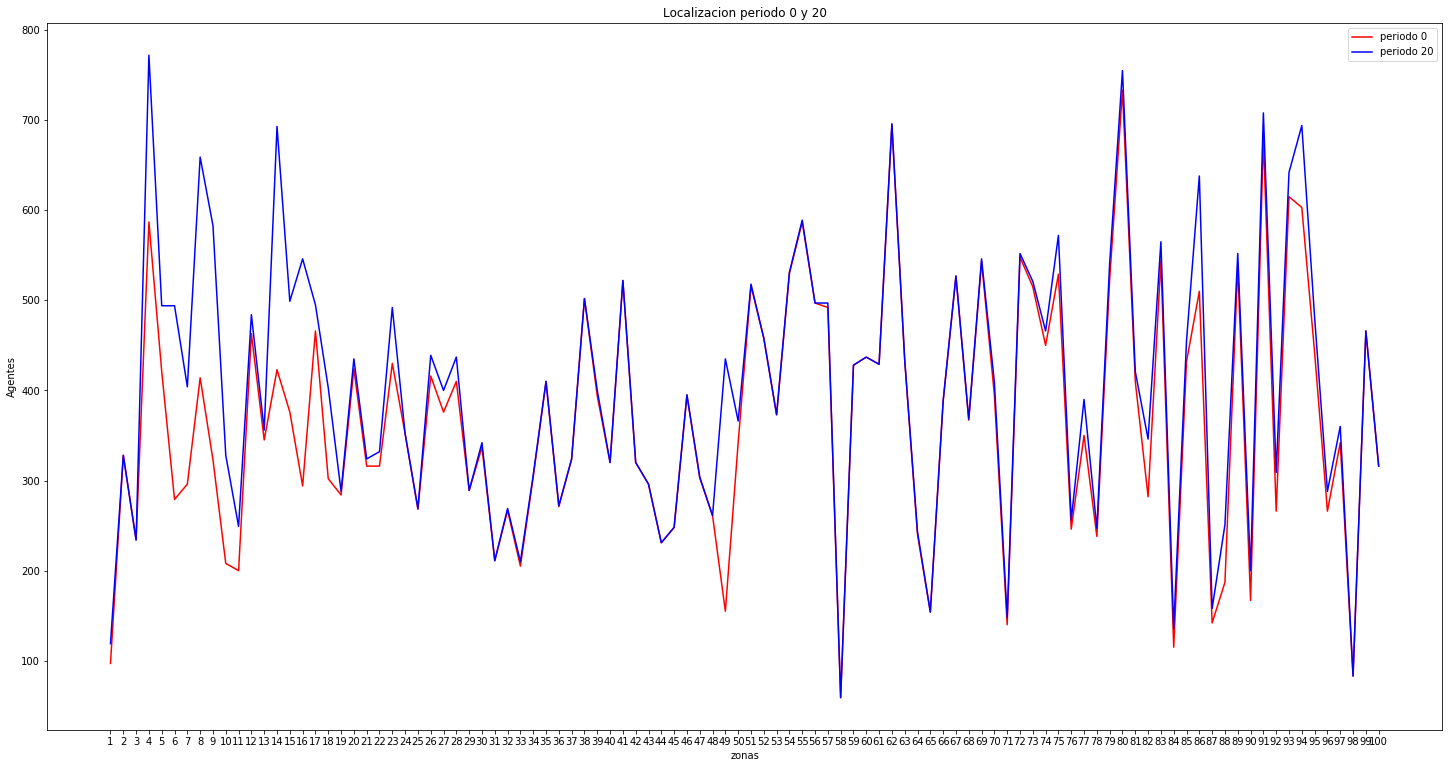

In [13]:
plot_comparar(zona,zonas,0,20)